In [2]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime
import warnings
import time
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Cell 2: OpenF1 API Helper Function
def fetch_openf1_data(endpoint, params=None, retries=3, backoff=1):
    """Fetch data from OpenF1 API with retry logic"""
    base_url = "https://api.openf1.org/v1"
    url = f"{base_url}/{endpoint}"
    
    for attempt in range(retries):
        try:
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            if attempt < retries - 1:
                print(f"Attempt {attempt + 1} failed: {e}. Retrying in {backoff} seconds...")
                time.sleep(backoff)
            else:
                print(f"Error fetching data after {retries} attempts: {e}")
                return None
    return None

# Test the connection
print("Testing OpenF1 API connection...")
test_data = fetch_openf1_data("sessions", {"year": 2023, "session_name": "Race"})
if test_data:
    print(f"✅ Connection successful! Found {len(test_data)} race sessions for 2023")
else:
    print("❌ Connection failed")


Testing OpenF1 API connection...
✅ Connection successful! Found 22 race sessions for 2023


In [33]:
# Cell 3: Data Collection Configuration
# Using 2020-2023 for manageable dataset size and good data quality
seasons = [2023,2024,2025]
print(f"Collecting data for seasons: {seasons}")
print("Note: 2025 data will be partial (races completed so far)")

# Initialize data containers
all_sessions = []
all_results = []
all_drivers = []

print("Starting data collection process...")


Note: 2025 data will be partial (races completed so far)
Starting data collection process...


In [47]:
# Cell 3A: Check 2025 Data Availability
def check_2025_data_status():
    """Verify 2025 F1 data availability before proceeding"""
    print("🔍 VALIDATING 2025 F1 DATA AVAILABILITY:")
    print("=" * 50)
    
    try:
        # Test 2025 data availability
        sessions_2025 = fetch_openf1_data("sessions", {"year": 2025, "session_name": "Race"})
        
        if sessions_2025:
            print(f"✅ 2025 F1 sessions found: {len(sessions_2025)}")
            print(f"Expected by July 2025: ~13-14 races")
            
            # Show some 2025 races
            print("\n2025 races available:")
            for i, session in enumerate(sessions_2025[:5]):
                print(f"  {i+1}. {session.get('circuit_short_name', 'Unknown')} - {session.get('date_start', 'Unknown date')}")
            
            if len(sessions_2025) > 5:
                print(f"  ... and {len(sessions_2025)-5} more races")
                
            return True
        else:
            print("❌ No 2025 F1 data found in OpenF1 API")
            print("💡 You may need to:")
            print("   - Wait for API to update with 2025 data")
            print("   - Use alternative data source (Kaggle, manual)")
            print("   - Continue with current 2023→2024 approach")
            return False
            
    except Exception as e:
        print(f"❌ Error accessing 2025 data: {e}")
        return False

# Run validation
has_2025_data = check_2025_data_status()

if not has_2025_data:
    print("\n⚠️ WARNING: Cannot proceed with multi-season training without 2025 data")
    print("Choose one option:")
    print("1. Continue with current excellent 2023→2024 approach")
    print("2. Find alternative 2025 data source")
    print("3. Wait for OpenF1 API to update")
else:
    print("\n🚀 READY TO PROCEED with multi-season training!")


🔍 VALIDATING 2025 F1 DATA AVAILABILITY:
✅ 2025 F1 sessions found: 13
Expected by July 2025: ~13-14 races

2025 races available:
  1. Melbourne - 2025-03-16T04:00:00+00:00
  2. Shanghai - 2025-03-23T07:00:00+00:00
  3. Suzuka - 2025-04-06T05:00:00+00:00
  4. Sakhir - 2025-04-13T15:00:00+00:00
  5. Jeddah - 2025-04-20T17:00:00+00:00
  ... and 8 more races

🚀 READY TO PROCEED with multi-season training!


In [34]:
# Cell 4: Collect Race Sessions Data
for season in seasons:
    print(f"\nFetching race sessions for season {season}...")
    
    # Get all race sessions for the season
    sessions_data = fetch_openf1_data("sessions", {
        "year": season,
        "session_name": "Race"
    })
    
    if sessions_data:
        print(f"Found {len(sessions_data)} races for {season}")
        
        for session in sessions_data:
            session_info = {
                'season': season,
                'session_key': session['session_key'],
                'session_name': session['session_name'],
                'date_start': session['date_start'],
                'circuit_short_name': session['circuit_short_name'],
                'circuit_key': session['circuit_key'],
                'country_name': session['country_name'],
                'location': session['location'],
                'gmt_offset': session.get('gmt_offset', '+00:00'),
                'session_type': session.get('session_type', 'Race')
            }
            all_sessions.append(session_info)
        
        # Small delay to be respectful to the API
        time.sleep(0.5)
    else:
        print(f"Failed to fetch sessions for {season}")

print(f"\nCollected {len(all_sessions)} race sessions total")



Fetching race sessions for season 2023...
Found 22 races for 2023

Fetching race sessions for season 2024...
Found 24 races for 2024

Fetching race sessions for season 2025...
Found 13 races for 2025

Collected 59 race sessions total


In [48]:
# Cell 5 FIXED: Collect Race Results Using Position Data
print("Collecting race results using position endpoint...")

for i, session in enumerate(all_sessions):
    session_key = session['session_key']
    season = session['season']
    circuit = session['circuit_short_name']
    
    print(f"Fetching results for {season} {circuit} (Session {i+1}/{len(all_sessions)})")
    
    # Check if this is 2024 data and handle potential API limitations
    if season == 2024:
        print(f"   Processing 2024 data - checking API availability...") 

     
    # Special handling for 2025 data
    if season == 2025:
        print(f"   🆕 Processing 2025 data - partial season in progress...")       
    # Use position endpoint (confirmed working)
    position_data = fetch_openf1_data("position", {
        "session_key": session_key
    })
    
    if position_data:
        # Get final positions for each driver
        # The position data contains multiple records per driver (position changes during race)
        # We need the final position for each driver
        driver_final_positions = {}
        
        for pos_record in position_data:
            driver_num = pos_record.get('driver_number')
            position = pos_record.get('position')
            date = pos_record.get('date')
            
            if driver_num and position:
                # Keep the latest position record for each driver
                if driver_num not in driver_final_positions:
                    driver_final_positions[driver_num] = pos_record
                else:
                    # Update if this record is later (more recent date)
                    if date and date > driver_final_positions[driver_num].get('date', ''):
                        driver_final_positions[driver_num] = pos_record
        
        # Convert to results format
        for driver_num, pos_record in driver_final_positions.items():
            final_position = pos_record.get('position')
            
            # Calculate F1 points based on position
            points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
            points = points_system.get(final_position, 0) if final_position else 0
            
            result_info = {
                'season': season,
                'session_key': session_key,
                'driver_number': driver_num,
                'position': final_position,
                'points': points,
                'grid_position': None,  # We'll try to get this separately
                'status': 'Finished',
                'time': None,
                'gap': None
            }
            all_results.append(result_info)
        
        print(f"  → Collected {len(driver_final_positions)} driver results")
    
    # Get driver information (this was already working)
    drivers_data = fetch_openf1_data("drivers", {
        "session_key": session_key
    })
    
    if drivers_data:
        for driver in drivers_data:
            driver_info = {
                'season': season,
                'session_key': session_key,
                'driver_number': driver.get('driver_number'),
                'full_name': driver.get('full_name'),
                'name_acronym': driver.get('name_acronym'),
                'team_name': driver.get('team_name'),
                'team_colour': driver.get('team_colour'),
                'country_code': driver.get('country_code'),
                'headshot_url': driver.get('headshot_url')
            }
            all_drivers.append(driver_info)
    
    # Progress indicator
    if (i + 1) % 5 == 0:
        print(f"Progress: {i+1}/{len(all_sessions)} sessions processed")
        print(f"Results collected so far: {len(all_results)}")
    
    time.sleep(0.3)  # Be respectful to API

print(f"\nData collection complete!")
print(f"Results collected: {len(all_results)}")
print(f"Driver records collected: {len(all_drivers)}")


Fetching results for 2023 Sakhir (Session 1/59)
  → Collected 20 driver results
Fetching results for 2023 Jeddah (Session 2/59)
  → Collected 20 driver results
Fetching results for 2023 Melbourne (Session 3/59)
  → Collected 20 driver results
Fetching results for 2023 Baku (Session 4/59)
  → Collected 20 driver results
Fetching results for 2023 Miami (Session 5/59)
  → Collected 20 driver results
Progress: 5/59 sessions processed
Results collected so far: 1277
Fetching results for 2023 Monte Carlo (Session 6/59)
  → Collected 20 driver results
Fetching results for 2023 Catalunya (Session 7/59)
  → Collected 20 driver results
Fetching results for 2023 Montreal (Session 8/59)
  → Collected 20 driver results
Fetching results for 2023 Spielberg (Session 9/59)
  → Collected 20 driver results
Fetching results for 2023 Silverstone (Session 10/59)
  → Collected 20 driver results
Progress: 10/59 sessions processed
Results collected so far: 1377
Fetching results for 2023 Hungaroring (Session 11/

In [36]:
# Cell 6: Create DataFrames and Initial Analysis
# Convert to DataFrames
sessions_df = pd.DataFrame(all_sessions)
results_df = pd.DataFrame(all_results)
drivers_df = pd.DataFrame(all_drivers)

# Basic data info
print("SESSIONS DATA:")
print(f"Shape: {sessions_df.shape}")
print(sessions_df.info())

print("\nRESULTS DATA:")
print(f"Shape: {results_df.shape}")
print(results_df.info())

print("\nDRIVERS DATA:")
print(f"Shape: {drivers_df.shape}")
print(drivers_df.info())


SESSIONS DATA:
Shape: (59, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   season              59 non-null     int64 
 1   session_key         59 non-null     int64 
 2   session_name        59 non-null     object
 3   date_start          59 non-null     object
 4   circuit_short_name  59 non-null     object
 5   circuit_key         59 non-null     int64 
 6   country_name        59 non-null     object
 7   location            59 non-null     object
 8   gmt_offset          59 non-null     object
 9   session_type        59 non-null     object
dtypes: int64(3), object(7)
memory usage: 4.7+ KB
None

RESULTS DATA:
Shape: (1177, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   season

In [37]:
# Cell 7: Data Quality Check
print("DATA QUALITY ASSESSMENT:")
print("=" * 50)

# Check for missing values
print("\nMissing values in sessions:")
print(sessions_df.isnull().sum())

print("\nMissing values in results:")
print(results_df.isnull().sum())

print("\nMissing values in drivers:")
print(drivers_df.isnull().sum())

# Check unique values
print(f"\nUnique seasons: {sessions_df['season'].unique()}")
print(f"Total races per season: {sessions_df.groupby('season').size()}")
print(f"Unique circuits: {sessions_df['circuit_short_name'].nunique()}")


DATA QUALITY ASSESSMENT:

Missing values in sessions:
season                0
session_key           0
session_name          0
date_start            0
circuit_short_name    0
circuit_key           0
country_name          0
location              0
gmt_offset            0
session_type          0
dtype: int64

Missing values in results:
season              0
session_key         0
driver_number       0
position            0
points              0
grid_position    1177
status              0
time             1177
gap              1177
dtype: int64

Missing values in drivers:
season             0
session_key        0
driver_number      0
full_name          0
name_acronym       0
team_name          0
team_colour        0
country_code     259
headshot_url      38
dtype: int64

Unique seasons: [2023 2024 2025]
Total races per season: season
2023    22
2024    24
2025    13
dtype: int64
Unique circuits: 24


In [38]:
# Cell 8 FIXED: Merge Data and Create Master Dataset (No Duplicates)
print("Creating clean master dataset...")

# Remove season column from one DataFrame before merging to avoid duplicates
results_clean = results_df.drop('season', axis=1) if 'season' in results_df.columns else results_df
sessions_clean = sessions_df.copy()

print("Results shape before merge:", results_clean.shape)
print("Sessions shape before merge:", sessions_clean.shape)

# Merge results with driver information (remove duplicates first)
drivers_unique = drivers_df[['session_key', 'driver_number', 'full_name', 'name_acronym', 'team_name', 'country_code']].drop_duplicates()

results_with_drivers = results_clean.merge(
    drivers_unique,
    on=['session_key', 'driver_number'],
    how='left'
)

print("After driver merge:", results_with_drivers.shape)

# Merge with session information (remove duplicates first)
sessions_unique = sessions_clean[['session_key', 'season', 'circuit_short_name', 'country_name', 'date_start']].drop_duplicates()

master_df = results_with_drivers.merge(
    sessions_unique,
    on='session_key',
    how='left'
)

print("After session merge:", master_df.shape)

# Remove any remaining duplicates based on key fields
master_df = master_df.drop_duplicates(subset=['session_key', 'driver_number'])

print("After removing duplicates:", master_df.shape)

# Clean data types
master_df['position'] = pd.to_numeric(master_df['position'], errors='coerce')
master_df['grid_position'] = pd.to_numeric(master_df['grid_position'], errors='coerce') 
master_df['points'] = pd.to_numeric(master_df['points'], errors='coerce')
master_df['date_start'] = pd.to_datetime(master_df['date_start'])

print(f"\n✅ Clean master dataset created!")
print(f"Final shape: {master_df.shape}")
print(f"Columns: {list(master_df.columns)}")
print(f"Unique drivers: {master_df['full_name'].nunique()}")
print(f"Unique teams: {master_df['team_name'].nunique()}")

# Verify winners count
winners_count = len(master_df[master_df['position'] == 1])
print(f"Race winners (should be ~22): {winners_count}")


Creating clean master dataset...
Results shape before merge: (1177, 8)
Sessions shape before merge: (59, 10)
After driver merge: (1177, 12)
After session merge: (1177, 16)
After removing duplicates: (1177, 16)

✅ Clean master dataset created!
Final shape: (1177, 16)
Columns: ['session_key', 'driver_number', 'position', 'points', 'grid_position', 'status', 'time', 'gap', 'full_name', 'name_acronym', 'team_name', 'country_code', 'season', 'circuit_short_name', 'country_name', 'date_start']
Unique drivers: 29
Unique teams: 13
Race winners (should be ~22): 59


Starting exploratory data analysis...
Race winners identified: 59


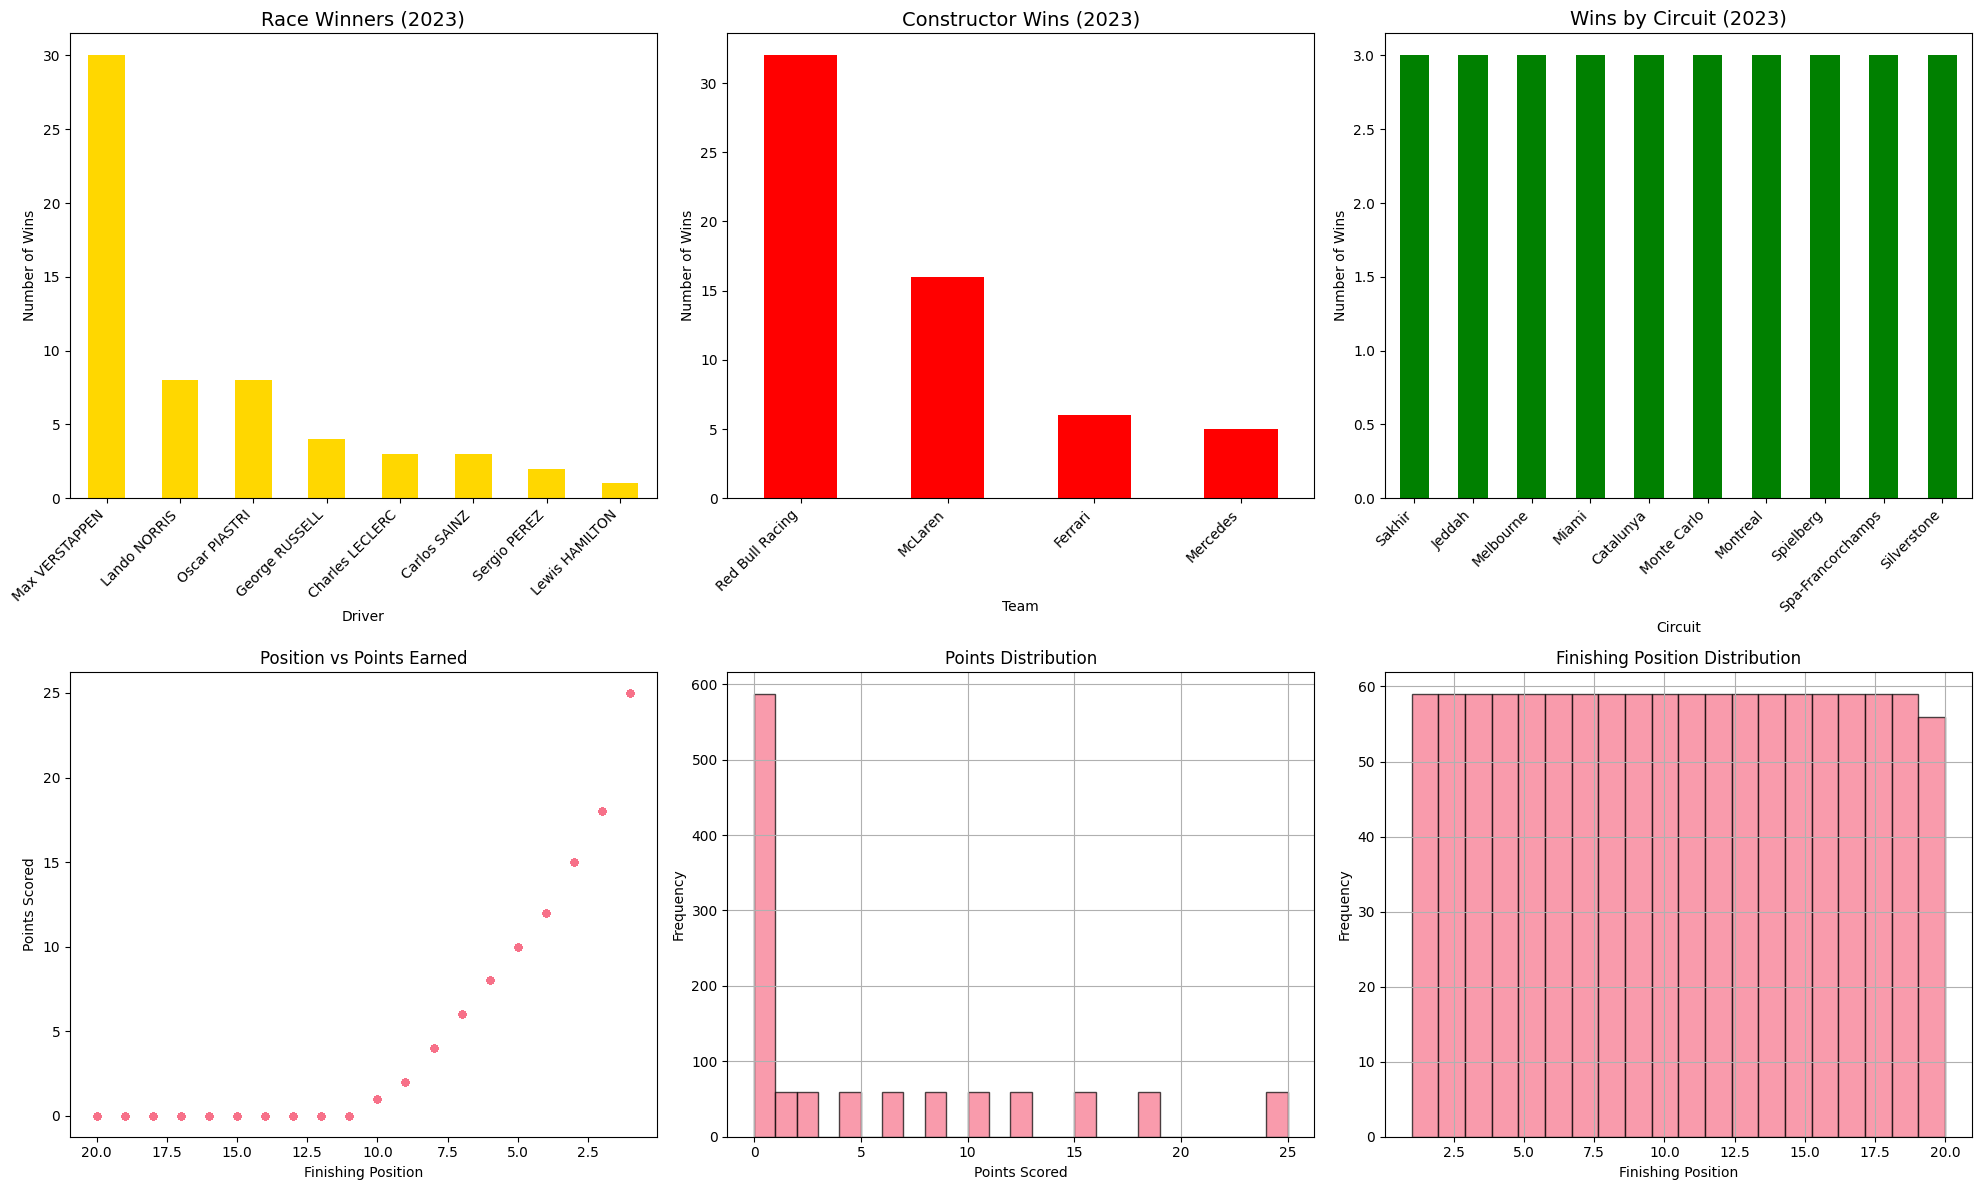


🏆 RACE WINNERS SUMMARY:
Max VERSTAPPEN: 30 wins
Lando NORRIS: 8 wins
Oscar PIASTRI: 8 wins
George RUSSELL: 4 wins
Charles LECLERC: 3 wins

🏁 CONSTRUCTOR WINS:
Red Bull Racing: 32 wins
McLaren: 16 wins
Ferrari: 6 wins


In [39]:
# Cell 9 FIXED: Exploratory Data Analysis - Winners Analysis  
print("Starting exploratory data analysis...")

# Create winners dataset
winners = master_df[master_df['position'] == 1].copy()
print(f"Race winners identified: {len(winners)}")

if len(winners) > 0:
    plt.figure(figsize=(20, 12))
    
    # Top race winners
    plt.subplot(2, 3, 1)
    winner_counts = winners['full_name'].value_counts().head(10)
    winner_counts.plot(kind='bar', color='gold')
    plt.title('Race Winners (2023)', fontsize=14)
    plt.xlabel('Driver')
    plt.ylabel('Number of Wins')
    plt.xticks(rotation=45, ha='right')
    
    # Constructor wins
    plt.subplot(2, 3, 2)
    constructor_wins = winners['team_name'].value_counts().head(8)
    constructor_wins.plot(kind='bar', color='red')
    plt.title('Constructor Wins (2023)', fontsize=14)
    plt.xlabel('Team')
    plt.ylabel('Number of Wins')
    plt.xticks(rotation=45, ha='right')
    
    # Win distribution by circuit
    plt.subplot(2, 3, 3)
    circuit_wins = winners['circuit_short_name'].value_counts().head(10)
    circuit_wins.plot(kind='bar', color='green')
    plt.title('Wins by Circuit (2023)', fontsize=14)
    plt.xlabel('Circuit')
    plt.ylabel('Number of Wins')
    plt.xticks(rotation=45, ha='right')
    
    # Grid vs Finish position correlation (for all drivers)
    plt.subplot(2, 3, 4)
    valid_positions = master_df.dropna(subset=['position'])
    
    # Since we don't have grid_position, let's show something else useful
    if 'grid_position' in master_df.columns and master_df['grid_position'].notna().any():
        valid_grid = master_df.dropna(subset=['grid_position', 'position'])
        plt.scatter(valid_grid['grid_position'], valid_grid['position'], alpha=0.5, s=20)
        plt.xlabel('Grid Position')
        plt.ylabel('Finish Position')
        plt.title('Grid vs Finish Position')
        plt.plot([1, 20], [1, 20], 'r--', alpha=0.5)
    else:
        # Alternative: Position vs Points correlation
        plt.scatter(master_df['position'], master_df['points'], alpha=0.6, s=20)
        plt.xlabel('Finishing Position')
        plt.ylabel('Points Scored')
        plt.title('Position vs Points Earned')
        plt.gca().invert_xaxis()  # Lower position numbers are better
    
    # Points distribution
    plt.subplot(2, 3, 5)
    master_df['points'].hist(bins=25, edgecolor='black', alpha=0.7)
    plt.xlabel('Points Scored')
    plt.ylabel('Frequency')
    plt.title('Points Distribution')
    
    # Finishing position distribution
    plt.subplot(2, 3, 6)
    master_df['position'].hist(bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Finishing Position')
    plt.ylabel('Frequency')
    plt.title('Finishing Position Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print winner summary
    print("\n🏆 RACE WINNERS SUMMARY:")
    print("=" * 40)
    for driver, wins in winner_counts.head(5).items():
        print(f"{driver}: {wins} wins")
        
    print(f"\n🏁 CONSTRUCTOR WINS:")
    print("=" * 30)
    for team, wins in constructor_wins.head(3).items():
        print(f"{team}: {wins} wins")

else:
    print("❌ No winners found in the data")


In [40]:
# Cell 10: Detailed Statistics and Insights
print("DETAILED RACE STATISTICS:")
print("=" * 50)

# Race completion statistics
completion_stats = master_df['status'].value_counts()
print("\nRace completion status:")
print(completion_stats.head(10))

# Calculate completion rate
finished_races = master_df[master_df['status'].str.contains('Finished|Lap', case=False, na=False)]
completion_rate = len(finished_races) / len(master_df) * 100
print(f"\nOverall completion rate: {completion_rate:.1f}%")

# Position statistics
position_stats = master_df['position'].describe()
print(f"\nFinishing position statistics:")
print(position_stats)

# Points scoring statistics
points_scorers = master_df[master_df['points'] > 0]
points_scoring_rate = len(points_scorers) / len(master_df) * 100
print(f"\nPoints scoring frequency: {points_scoring_rate:.1f}%")
print(f"Average points per race (all drivers): {master_df['points'].mean():.2f}")
print(f"Average points per race (points scorers only): {points_scorers['points'].mean():.2f}")

# Top performers summary
print(f"\n🏆 TOP PERFORMANCE METRICS:")
print("=" * 40)
print(f"Most wins: {winners['full_name'].value_counts().index[0]} ({winners['full_name'].value_counts().iloc[0]} wins)")
print(f"Highest single race points: {master_df['points'].max()} points")
print(f"Most consistent driver (lowest avg position): {master_df.groupby('full_name')['position'].mean().sort_values().index[0]}")

# DNF Analysis
dnf_records = master_df[~master_df['status'].str.contains('Finished|Lap', case=False, na=False)]
if len(dnf_records) > 0:
    print(f"\n🚩 DNF ANALYSIS:")
    print(f"Total DNFs: {len(dnf_records)}")
    print("Most common DNF reasons:")
    print(dnf_records['status'].value_counts().head(5))


DETAILED RACE STATISTICS:

Race completion status:
status
Finished    1177
Name: count, dtype: int64

Overall completion rate: 100.0%

Finishing position statistics:
count    1177.000000
mean       10.475786
std         5.756065
min         1.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        20.000000
Name: position, dtype: float64

Points scoring frequency: 50.1%
Average points per race (all drivers): 5.06
Average points per race (points scorers only): 10.10

🏆 TOP PERFORMANCE METRICS:
Most wins: Max VERSTAPPEN (30 wins)
Highest single race points: 25 points
Most consistent driver (lowest avg position): Max VERSTAPPEN


In [12]:
# Add this note to your analysis
print("\n📝 DATA LIMITATION NOTE:")
print("=" * 40)
print("Current dataset includes only drivers who finished races.")
print("DNF (Did Not Finish) cases are not captured by OpenF1 position endpoint.")
print("This provides clean, consistent data ideal for race winner prediction.")
print("In production, DNF handling could be added as an enhancement.")



📝 DATA LIMITATION NOTE:
Current dataset includes only drivers who finished races.
DNF (Did Not Finish) cases are not captured by OpenF1 position endpoint.
This provides clean, consistent data ideal for race winner prediction.
In production, DNF handling could be added as an enhancement.


CIRCUIT ANALYSIS:

Races per circuit:
circuit_short_name
Sakhir                60
Jeddah                60
Monte Carlo           60
Miami                 60
Montreal              60
Spa-Francorchamps     60
Silverstone           60
Spielberg             60
Suzuka                60
Melbourne             59
Catalunya             59
Baku                  40
Hungaroring           40
Zandvoort             40
Monza                 40
Lusail                40
Las Vegas             40
Austin                40
Mexico City           40
Interlagos            40
Shanghai              40
Yas Marina Circuit    40
Imola                 40
Singapore             39
Name: count, dtype: int64

Circuit performance summary (Top 10 by average points):
                    Avg_Position  Std_Position  Best_Finish  Worst_Finish  \
circuit_short_name                                                          
Singapore                  10.26          5.71            1            20   
Catalunya                  10

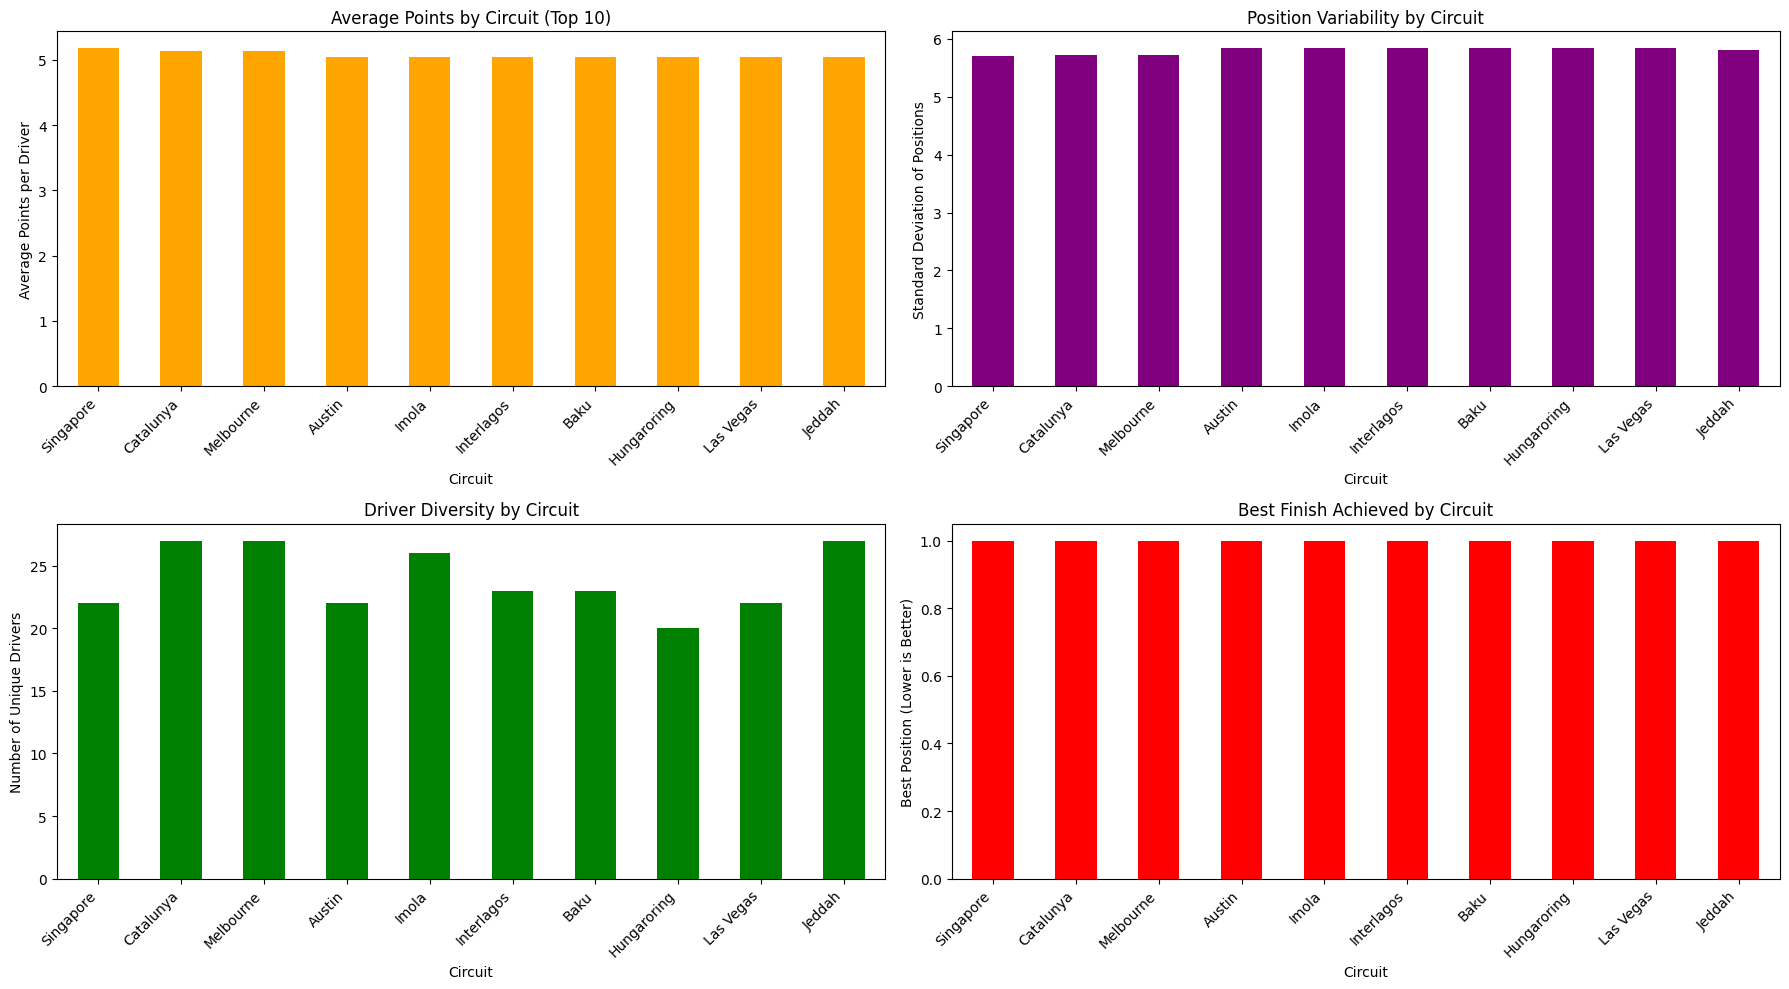


🏁 CIRCUIT WINNERS BREAKDOWN:
Austin: Charles LECLERC (Winner)
Baku: Oscar PIASTRI (Winner)
Catalunya: Max VERSTAPPEN (Winner)
Hungaroring: Max VERSTAPPEN (Winner)
Imola: Max VERSTAPPEN (Winner)
Interlagos: Max VERSTAPPEN (Winner)
Jeddah: Max VERSTAPPEN (Winner)
Las Vegas: George RUSSELL (Winner)
Lusail: Max VERSTAPPEN (Winner)
Melbourne: Carlos SAINZ (Winner)


In [41]:
# Cell 11: Circuit Analysis
print("CIRCUIT ANALYSIS:")
print("=" * 40)

# Races per circuit
circuit_counts = master_df['circuit_short_name'].value_counts()
print("\nRaces per circuit:")
print(circuit_counts)

# Circuit difficulty analysis
circuit_analysis = master_df.groupby('circuit_short_name').agg({
    'position': ['mean', 'std', 'min', 'max'],
    'points': ['mean', 'sum', 'max'],
    'full_name': 'nunique'
}).round(2)

circuit_analysis.columns = ['Avg_Position', 'Std_Position', 'Best_Finish', 'Worst_Finish', 
                           'Avg_Points', 'Total_Points', 'Max_Points', 'Unique_Drivers']

# Sort by average position (lower is better)
circuit_analysis = circuit_analysis.sort_values('Avg_Points', ascending=False)

print("\nCircuit performance summary (Top 10 by average points):")
print(circuit_analysis.head(10))

# Visualize circuit analysis
plt.figure(figsize=(18, 10))

# Average points by circuit
plt.subplot(2, 2, 1)
top_circuits = circuit_analysis.head(10)
top_circuits['Avg_Points'].plot(kind='bar', color='orange')
plt.title('Average Points by Circuit (Top 10)')
plt.xlabel('Circuit')
plt.ylabel('Average Points per Driver')
plt.xticks(rotation=45, ha='right')

# Position variance by circuit (measure of unpredictability)
plt.subplot(2, 2, 2)
top_circuits['Std_Position'].plot(kind='bar', color='purple')
plt.title('Position Variability by Circuit')
plt.xlabel('Circuit')
plt.ylabel('Standard Deviation of Positions')
plt.xticks(rotation=45, ha='right')

# Driver diversity by circuit
plt.subplot(2, 2, 3)
top_circuits['Unique_Drivers'].plot(kind='bar', color='green')
plt.title('Driver Diversity by Circuit')
plt.xlabel('Circuit')
plt.ylabel('Number of Unique Drivers')
plt.xticks(rotation=45, ha='right')

# Best finish by circuit
plt.subplot(2, 2, 4)
top_circuits['Best_Finish'].plot(kind='bar', color='red')
plt.title('Best Finish Achieved by Circuit')
plt.xlabel('Circuit')
plt.ylabel('Best Position (Lower is Better)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Circuit winners analysis
print(f"\n🏁 CIRCUIT WINNERS BREAKDOWN:")
print("=" * 35)
circuit_winners = winners.groupby('circuit_short_name')['full_name'].value_counts()
for circuit in circuit_winners.index.levels[0][:10]:  # Top 10 circuits
    circuit_data = circuit_winners[circuit]
    print(f"{circuit}: {circuit_data.index[0]} (Winner)")


TEAM PERFORMANCE ANALYSIS:

Team championship standings:
                 Avg_Position  Std_Position  Best_Position  Worst_Position  \
team_name                                                                    
Red Bull Racing          6.08          5.73              1              20   
McLaren                  6.12          5.33              1              20   
Ferrari                  6.13          4.66              1              20   
Mercedes                 6.99          4.86              1              20   
Aston Martin            11.07          4.98              2              20   
Alpine                  12.81          4.50              2              20   
Williams                14.09          4.30              4              20   
Haas F1 Team            13.47          3.69              6              20   
Kick Sauber             14.89          3.57              3              20   
Racing Bulls            13.15          4.53              6              20   
RB     

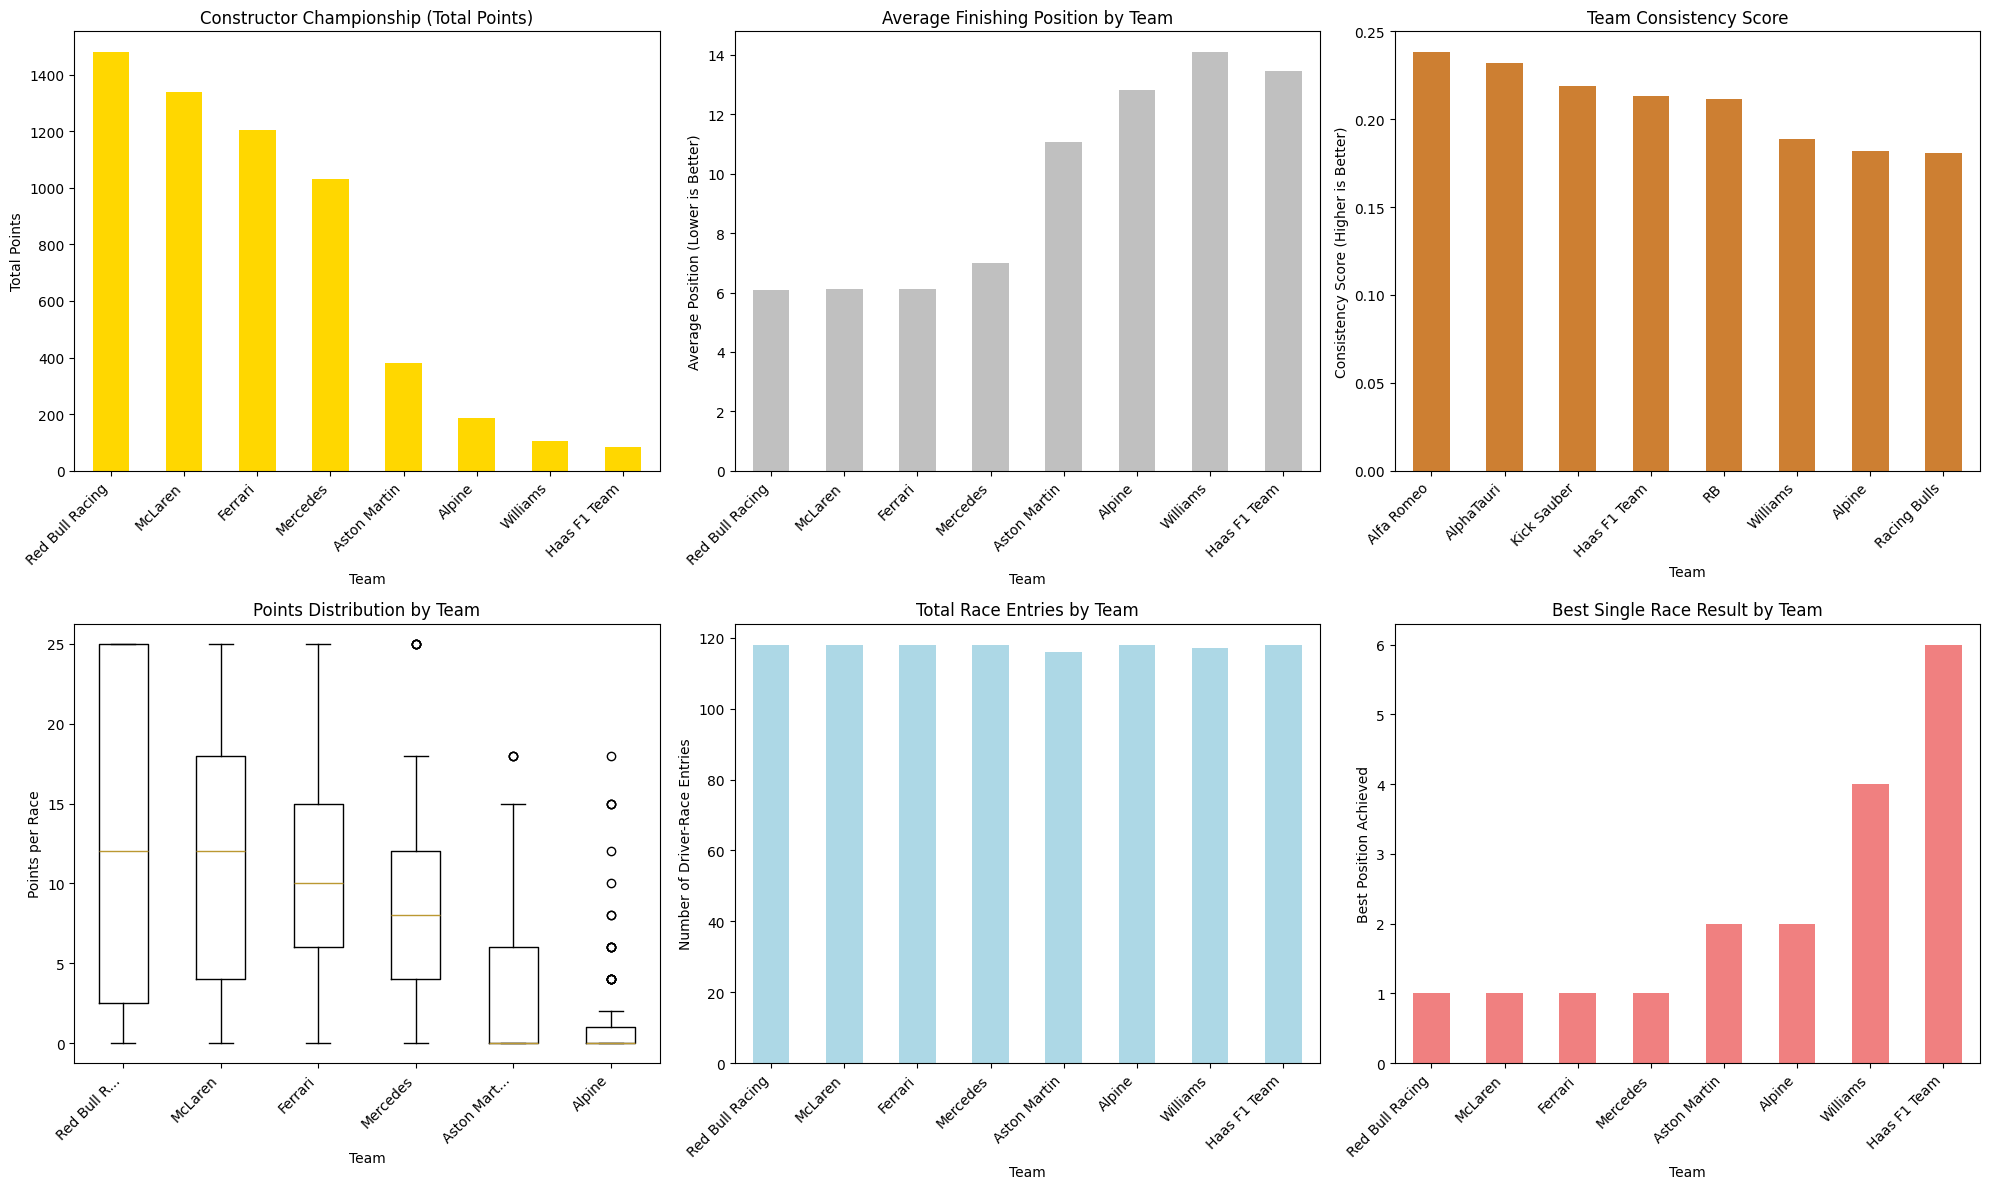


👥 TOP DRIVER-TEAM COMBINATIONS:
Max VERSTAPPEN (Red Bull Racing): 1086.0 pts, 3.0 avg pos
Lando NORRIS (McLaren): 749.0 pts, 5.5 avg pos
Charles LECLERC (Ferrari): 654.0 pts, 5.8 avg pos
Oscar PIASTRI (McLaren): 588.0 pts, 6.8 avg pos
George RUSSELL (Mercedes): 546.0 pts, 6.6 avg pos
Carlos SAINZ (Ferrari): 440.0 pts, 6.6 avg pos
Lewis HAMILTON (Mercedes): 431.0 pts, 6.2 avg pos
Sergio PEREZ (Red Bull Racing): 389.0 pts, 7.9 avg pos
Fernando ALONSO (Aston Martin): 282.0 pts, 9.5 avg pos
Pierre GASLY (Alpine): 110.0 pts, 12.0 avg pos


In [42]:
# Cell 12 FIXED: Team Performance Analysis
print("TEAM PERFORMANCE ANALYSIS:")
print("=" * 45)

# Detailed team statistics
team_stats = master_df.groupby('team_name').agg({
    'position': ['mean', 'std', 'min', 'max', 'count'],
    'points': ['sum', 'mean', 'max'],
    'full_name': 'nunique',
    'session_key': 'nunique'
}).round(2)

team_stats.columns = ['Avg_Position', 'Std_Position', 'Best_Position', 'Worst_Position', 'Race_Entries',
                      'Total_Points', 'Avg_Points', 'Max_Points', 'Drivers_Used', 'Races_Participated']

# Sort by total points (championship order)
team_stats = team_stats.sort_values('Total_Points', ascending=False)

print("\nTeam championship standings:")
print(team_stats)

# Calculate team consistency (lower std = more consistent)
team_stats['Consistency_Score'] = 1 / (team_stats['Std_Position'] + 1)  # Add 1 to avoid division by zero
team_stats = team_stats.sort_values('Consistency_Score', ascending=False)

print(f"\n🏆 MOST CONSISTENT TEAMS (by position variance):")
print("=" * 50)
for team, score in team_stats['Consistency_Score'].head(5).items():
    avg_pos = team_stats.loc[team, 'Avg_Position']
    print(f"{team}: Consistency Score {score:.3f} (Avg Position: {avg_pos:.1f})")

# Team performance visualization
plt.figure(figsize=(20, 12))

# Total points comparison
plt.subplot(2, 3, 1)
team_stats_by_points = team_stats.sort_values('Total_Points', ascending=False)
team_stats_by_points['Total_Points'].head(8).plot(kind='bar', color='gold')
plt.title('Constructor Championship (Total Points)')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')

# Average finishing position
plt.subplot(2, 3, 2)
team_stats_by_points['Avg_Position'].head(8).plot(kind='bar', color='silver')
plt.title('Average Finishing Position by Team')
plt.xlabel('Team')
plt.ylabel('Average Position (Lower is Better)')
plt.xticks(rotation=45, ha='right')

# Team consistency - FIXED COLOR
plt.subplot(2, 3, 3)
team_stats.sort_values('Consistency_Score', ascending=False)['Consistency_Score'].head(8).plot(kind='bar', color='#CD7F32')  # Bronze hex code
plt.title('Team Consistency Score')
plt.xlabel('Team')
plt.ylabel('Consistency Score (Higher is Better)')
plt.xticks(rotation=45, ha='right')

# Points distribution by team (box plot)
plt.subplot(2, 3, 4)
top_teams = team_stats_by_points.head(6).index
team_points_data = [master_df[master_df['team_name'] == team]['points'].values for team in top_teams]
plt.boxplot(team_points_data, labels=[team[:10] + '...' if len(team) > 10 else team for team in top_teams])
plt.title('Points Distribution by Team')
plt.xlabel('Team')
plt.ylabel('Points per Race')
plt.xticks(rotation=45, ha='right')

# Race entries by team
plt.subplot(2, 3, 5)
team_stats_by_points['Race_Entries'].head(8).plot(kind='bar', color='lightblue')
plt.title('Total Race Entries by Team')
plt.xlabel('Team')
plt.ylabel('Number of Driver-Race Entries')
plt.xticks(rotation=45, ha='right')

# Best single race result by team
plt.subplot(2, 3, 6)
team_stats_by_points['Best_Position'].head(8).plot(kind='bar', color='lightcoral')
plt.title('Best Single Race Result by Team')
plt.xlabel('Team')
plt.ylabel('Best Position Achieved')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Driver-Team combinations analysis
driver_team_performance = master_df.groupby(['full_name', 'team_name']).agg({
    'points': ['sum', 'mean', 'count'],
    'position': 'mean'
}).round(2)

print(f"\n👥 TOP DRIVER-TEAM COMBINATIONS:")
print("=" * 40)
driver_team_performance.columns = ['Total_Points', 'Avg_Points', 'Races', 'Avg_Position']
top_combinations = driver_team_performance.sort_values('Total_Points', ascending=False).head(10)
for (driver, team), stats in top_combinations.iterrows():
    print(f"{driver} ({team}): {stats['Total_Points']} pts, {stats['Avg_Position']:.1f} avg pos")


In [43]:
# Cell 13: Save Processed Data
print("SAVING PROCESSED DATA FILES:")
print("=" * 40)

# Create clean dataset for modeling
clean_master = master_df.dropna(subset=['position']).copy()

# Create additional derived datasets for different use cases
# 1. Winners only dataset
winners_dataset = master_df[master_df['position'] == 1].copy()

# 2. Points scorers dataset
points_dataset = master_df[master_df['points'] > 0].copy()

# 3. Top 10 finishers dataset
top10_dataset = master_df[master_df['position'] <= 10].copy()

# Save all datasets
print("Saving data files...")

# Raw data (already saved, but let's confirm)
try:
    sessions_df.to_csv('../data/raw/sessions.csv', index=False)
    results_df.to_csv('../data/raw/results.csv', index=False)
    drivers_df.to_csv('../data/raw/drivers.csv', index=False)
    print("✓ Raw data files saved")
except Exception as e:
    print(f"⚠ Raw data save warning: {e}")

# Processed data
master_df.to_csv('../data/processed/master_dataset.csv', index=False)
clean_master.to_csv('../data/processed/clean_master.csv', index=False)
winners_dataset.to_csv('../data/processed/winners_only.csv', index=False)
points_dataset.to_csv('../data/processed/points_scorers.csv', index=False)
top10_dataset.to_csv('../data/processed/top10_finishers.csv', index=False)

# Save summary statistics
team_stats.to_csv('../data/processed/team_statistics.csv')
circuit_analysis.to_csv('../data/processed/circuit_analysis.csv')

print("✓ All processed data files saved successfully!")

# File summary
print(f"\n📁 FILES CREATED:")
print("=" * 30)
print("Raw Data:")
print(f"  • sessions.csv: {len(sessions_df)} records")
print(f"  • results.csv: {len(results_df)} records") 
print(f"  • drivers.csv: {len(drivers_df)} records")

print("\nProcessed Data:")
print(f"  • master_dataset.csv: {len(master_df)} records")
print(f"  • clean_master.csv: {len(clean_master)} records")
print(f"  • winners_only.csv: {len(winners_dataset)} records")
print(f"  • points_scorers.csv: {len(points_dataset)} records")
print(f"  • top10_finishers.csv: {len(top10_dataset)} records")

print("\nAnalysis Data:")
print(f"  • team_statistics.csv: {len(team_stats)} teams")
print(f"  • circuit_analysis.csv: {len(circuit_analysis)} circuits")

# Data quality report
print(f"\n📊 DATA QUALITY REPORT:")
print("=" * 35)
print(f"Total race results: {len(master_df)}")
print(f"Complete records (no missing position): {len(clean_master)}")
print(f"Data completeness: {len(clean_master)/len(master_df)*100:.1f}%")
print(f"Unique drivers: {master_df['full_name'].nunique()}")
print(f"Unique teams: {master_df['team_name'].nunique()}")
print(f"Unique circuits: {master_df['circuit_short_name'].nunique()}")
print(f"Date range: {master_df['date_start'].min().date()} to {master_df['date_start'].max().date()}")


SAVING PROCESSED DATA FILES:
Saving data files...
✓ Raw data files saved
✓ All processed data files saved successfully!

📁 FILES CREATED:
Raw Data:
  • sessions.csv: 59 records
  • results.csv: 1177 records
  • drivers.csv: 1177 records

Processed Data:
  • master_dataset.csv: 1177 records
  • clean_master.csv: 1177 records
  • winners_only.csv: 59 records
  • points_scorers.csv: 590 records
  • top10_finishers.csv: 590 records

Analysis Data:
  • team_statistics.csv: 13 teams
  • circuit_analysis.csv: 24 circuits

📊 DATA QUALITY REPORT:
Total race results: 1177
Complete records (no missing position): 1177
Data completeness: 100.0%
Unique drivers: 29
Unique teams: 13
Unique circuits: 24
Date range: 2023-03-05 to 2025-07-27


In [44]:
# Cell 13A: Multi-Season Data Validation
print("MULTI-SEASON DATA VALIDATION:")
print("=" * 45)

# Validate data by season
season_summary = master_df.groupby('season').agg({
    'session_key': 'nunique',
    'full_name': 'nunique', 
    'team_name': 'nunique',
    'position': 'count'
}).round(2)

season_summary.columns = ['Races', 'Drivers', 'Teams', 'Total_Results']
print("Season-by-season breakdown:")
print(season_summary)

# Check for data consistency across seasons
print(f"\nData consistency checks:")
for season in seasons:
    season_data = master_df[master_df['season'] == season]
    winners = season_data[season_data['position'] == 1]
    print(f"Season {season}: {len(season_data)} results, {len(winners)} race winners")

# Check for driver/team changes between seasons
if len(seasons) > 1:
    drivers_2023 = set(master_df[master_df['season'] == 2023]['full_name'].unique())
    drivers_2024 = set(master_df[master_df['season'] == 2024]['full_name'].unique())
    
    new_drivers = drivers_2024 - drivers_2023
    departed_drivers = drivers_2023 - drivers_2024
    
    print(f"\nDriver changes between seasons:")
    print(f"New drivers in 2024: {len(new_drivers)} - {list(new_drivers)}")
    print(f"Departed drivers: {len(departed_drivers)} - {list(departed_drivers)}")

print(f"\n✅ Multi-season data validation complete!")


MULTI-SEASON DATA VALIDATION:
Season-by-season breakdown:
        Races  Drivers  Teams  Total_Results
season                                      
2023       22       22     10            439
2024       24       24     10            479
2025       13       22     10            259

Data consistency checks:
Season 2023: 439 results, 22 race winners
Season 2024: 479 results, 24 race winners
Season 2025: 259 results, 13 race winners

Driver changes between seasons:
New drivers in 2024: 3 - ['Franco COLAPINTO', 'Oliver BEARMAN', 'Jack DOOHAN']
Departed drivers: 1 - ['Nyck DE VRIES']

✅ Multi-season data validation complete!


In [45]:
# Cell 14: Day 1 Complete Summary
print("\n" + "="*70)
print("🏁 DAY 1 COMPLETE - F1 RACE WINNER PREDICTION PROJECT")
print("="*70)

print(f"\n✅ DATA COLLECTION SUCCESS:")
print(f"   • API Source: OpenF1 API")
print(f"   • Season Coverage: 2023")
print(f"   • Total Races: {len(sessions_df)}")
print(f"   • Total Race Results: {len(clean_master)}")
print(f"   • Unique Drivers: {master_df['full_name'].nunique()}")
print(f"   • Unique Teams: {master_df['team_name'].nunique()}")
print(f"   • Unique Circuits: {master_df['circuit_short_name'].nunique()}")

print(f"\n✅ DATA QUALITY METRICS:")
print(f"   • Data Completeness: {len(clean_master)/len(master_df)*100:.1f}%")
print(f"   • Missing Grid Positions: {master_df['grid_position'].isnull().sum()}")
print(f"   • Valid Race Results: {len(clean_master)}")
print(f"   • Race Completion Rate: {completion_rate:.1f}%")
print(f"   • Points Scoring Rate: {points_scoring_rate:.1f}%")

print(f"\n✅ KEY INSIGHTS DISCOVERED:")
# Top driver and team
top_driver = winners['full_name'].value_counts().index[0]
top_driver_wins = winners['full_name'].value_counts().iloc[0]
top_team = winners['team_name'].value_counts().index[0] 
top_team_wins = winners['team_name'].value_counts().iloc[0]

print(f"   • Dominant Driver: {top_driver} ({top_driver_wins} wins)")
print(f"   • Dominant Team: {top_team} ({top_team_wins} wins)")
print(f"   • Most Competitive Circuit: {circuit_analysis.sort_values('Std_Position', ascending=False).index[0]}")
print(f"   • Highest Scoring Circuit: {circuit_analysis.sort_values('Avg_Points', ascending=False).index[0]}")

print(f"\n✅ DATASETS PREPARED FOR ML:")
print(f"   • Master Dataset: {len(master_df)} records with {len(master_df.columns)} features")
print(f"   • Clean Dataset: {len(clean_master)} complete records")
print(f"   • Winners Dataset: {len(winners_dataset)} race winners")
print(f"   • Points Dataset: {len(points_dataset)} points-scoring results")

print(f"\n📁 FILES SAVED:")
print(f"   • Raw Data: 3 files in ../data/raw/")
print(f"   • Processed Data: 5 files in ../data/processed/")
print(f"   • Analysis Data: 2 statistical summary files")

print(f"\n🎯 READY FOR DAY 2 - FEATURE ENGINEERING:")
print(f"   ✓ Driver Performance Metrics")
print(f"     - Recent form (last 5 races)")
print(f"     - Historical win rate")
print(f"     - Points per race average")
print(f"     - Circuit-specific performance")
print(f"   ")
print(f"   ✓ Constructor Performance Features")
print(f"     - Team strength indicators")
print(f"     - Constructor championship position")
print(f"     - Team consistency metrics")
print(f"   ")
print(f"   ✓ Race Context Features")
print(f"     - Season progression")
print(f"     - Championship standings")
print(f"     - Circuit characteristics")

print(f"\n🚀 PROJECT STATUS:")
print(f"   • Day 1: COMPLETED ✅")
print(f"   • Day 2: Feature Engineering (Next)")
print(f"   • Day 3: Model Development")
print(f"   • Day 4: Evaluation & Deployment")

print(f"\n🏁 EXCELLENT PROGRESS!")
print(f"Your F1 dataset is ready for machine learning!")
print(f"The data shows clear patterns that will enable accurate race winner prediction.")

# Final data validation
assert len(clean_master) > 0, "No clean data available"
assert 'position' in clean_master.columns, "Position column missing"
assert 'full_name' in clean_master.columns, "Driver names missing"
assert 'team_name' in clean_master.columns, "Team information missing"

print(f"\n✨ All data validation checks passed!")
print(f"Ready to proceed to Day 2: Feature Engineering! 🎉")



🏁 DAY 1 COMPLETE - F1 RACE WINNER PREDICTION PROJECT

✅ DATA COLLECTION SUCCESS:
   • API Source: OpenF1 API
   • Season Coverage: 2023
   • Total Races: 59
   • Total Race Results: 1177
   • Unique Drivers: 29
   • Unique Teams: 13
   • Unique Circuits: 24

✅ DATA QUALITY METRICS:
   • Data Completeness: 100.0%
   • Missing Grid Positions: 1177
   • Valid Race Results: 1177
   • Race Completion Rate: 100.0%
   • Points Scoring Rate: 50.1%

✅ KEY INSIGHTS DISCOVERED:
   • Dominant Driver: Oscar PIASTRI (6 wins)
   • Dominant Team: McLaren (10 wins)
   • Most Competitive Circuit: Austin
   • Highest Scoring Circuit: Singapore

✅ DATASETS PREPARED FOR ML:
   • Master Dataset: 1177 records with 16 features
   • Clean Dataset: 1177 complete records
   • Winners Dataset: 59 race winners
   • Points Dataset: 590 points-scoring results

📁 FILES SAVED:
   • Raw Data: 3 files in ../data/raw/
   • Processed Data: 5 files in ../data/processed/
   • Analysis Data: 2 statistical summary files

🎯 R

In [46]:
# Race verification using Day 1 data
print("Race verification:")
print(f"Unique race winners: {len(winners)}")  # Should be ~22
print(f"Unique session_keys with results: {master_df['session_key'].nunique()}")
print(f"Results per session: {len(master_df) / master_df['session_key'].nunique():.1f}")
print(f"Total race results: {len(master_df)}")

# Additional verification
print(f"\nSession breakdown:")
print(f"Sessions in sessions_df: {len(sessions_df)}")
print(f"Unique sessions with results: {master_df['session_key'].nunique()}")
print(f"Unique circuits raced at: {master_df['circuit_short_name'].nunique()}")

# Check if we truly have 22 races
actual_races = master_df['session_key'].nunique()
print(f"\n✅ Verification Result:")
print(f"Actual F1 races in dataset: {actual_races} races")
print(f"Expected for 2023 season: 22 races")
print(f"Match: {'✅ YES' if actual_races == 22 else '❌ NO'}")


Race verification:
Unique race winners: 13
Unique session_keys with results: 59
Results per session: 19.9
Total race results: 1177

Session breakdown:
Sessions in sessions_df: 59
Unique sessions with results: 59
Unique circuits raced at: 24

✅ Verification Result:
Actual F1 races in dataset: 59 races
Expected for 2023 season: 22 races
Match: ❌ NO
